In [1]:
import pynucastro as pyna

In [2]:
rates = ["p-p-d-ec",
         "d-pg-he3-de04",
         "he3-he3pp-he4-nacr"]

In [3]:
net = pyna.RateCollection(rates)

In [4]:
print(net.network_overview())

p
  consumed by:
     p + p + e⁻ ⟶ H2 + 𝜈
     H2 + p ⟶ He3 + 𝛾
  produced by:
     He3 + He3 ⟶ p + p + He4

d
  consumed by:
     H2 + p ⟶ He3 + 𝛾
  produced by:
     p + p + e⁻ ⟶ H2 + 𝜈

He3
  consumed by:
     He3 + He3 ⟶ p + p + He4
  produced by:
     H2 + p ⟶ He3 + 𝛾

He4
  consumed by:
  produced by:
     He3 + He3 ⟶ p + p + He4




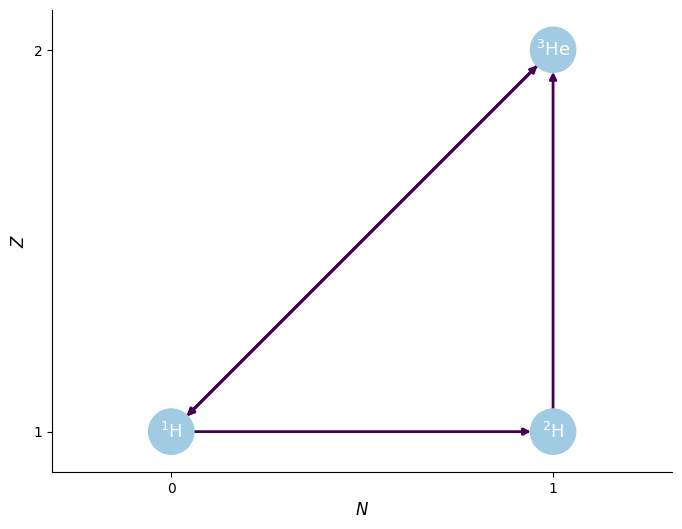

In [5]:
fig = net.plot()

In [6]:
pynet = pyna.PythonNetwork(rates)

In [7]:
pynet.write_network()

import numba
import numpy as np
from numba.experimental import jitclass

from pynucastro.rates import TableIndex, TableInterpolator, TabularRate, Tfactors
from pynucastro.screening import PlasmaState, ScreenFactors

jp = 0
jd = 1
jhe3 = 2
jhe4 = 3
nnuc = 4

A = np.zeros((nnuc), dtype=np.int32)

A[jp] = 1
A[jd] = 2
A[jhe3] = 3
A[jhe4] = 4

Z = np.zeros((nnuc), dtype=np.int32)

Z[jp] = 1
Z[jd] = 1
Z[jhe3] = 2
Z[jhe4] = 2

names = []
names.append("H1")
names.append("H2")
names.append("He3")
names.append("He4")

def to_composition(Y):
    """Convert an array of molar fractions to a Composition object."""
    from pynucastro import Composition, Nucleus
    nuclei = [Nucleus.from_cache(name) for name in names]
    comp = Composition(nuclei)
    for i, nuc in enumerate(nuclei):
        comp.X[nuc] = Y[i] * A[i]
    return comp

@jitclass([
    ("p_p__d__weak__electron_capture", numba.float64),
    ("p_d__He3", numba.float64),
    ("He3_He3__p_p_He4", numba.float64),
])
class RateEval:
    def